# Baseline: Classical Autoencoder
A classical benchmark for the quantum enhanced autoencoder, following the structure given in "Applying Quantum Autoencoders for Time Series Anomaly Detection", published 10/10/2024, by Robin Frehner, Kurt Stockinger.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive

In [2]:
# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Paths to your dataset
train_file_path = '/content/drive/My Drive/UCRArchive_2018/Fish/Fish_TRAIN.tsv'
test_file_path = '/content/drive/My Drive/UCRArchive_2018/Fish/Fish_TEST.tsv'

In [4]:
# Load the data
def load_data(file_path):
    data = pd.read_csv(file_path, sep='\t', header=None)
    data = data.iloc[:, 1:]  # Remove the first useless column
    return data.values

train_data = load_data(train_file_path)
test_data = load_data(test_file_path)

# Normalize the data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)


In [5]:
train_data.shape

(175, 463)

In [6]:
# PyTorch Dataset and DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx].unsqueeze(0)

train_dataset = TimeSeriesDataset(train_data)
test_dataset = TimeSeriesDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [7]:
class Autoencoder(nn.Module):
    def __init__(self, window_size, input_size):
        super(Autoencoder, self).__init__()
        self.encoder_lstm = nn.LSTM(input_size=input_size, hidden_size=window_size, batch_first=True)
        self.encoder_fc = nn.Sequential(
            nn.ReLU(),
            nn.Linear(window_size, 10),
            nn.ReLU(),
            nn.Linear(10, 4)
        )
        self.decoder_fc = nn.Sequential(
            nn.Linear(4, 10),
            nn.ReLU(),
            nn.Linear(10, window_size),
            nn.ReLU()
        )
        self.decoder_lstm = nn.LSTM(input_size=window_size, hidden_size=input_size, batch_first=True)


    def forward(self, x):
        # Encoding: Pass through the encoder layers
        outputs, (h_n, c_n) = self.encoder_lstm(x)  # Pass through LSTM layer, get output and hidden states
        encoded = self.encoder_fc(outputs[:, -1, :])  # Pass the last output of the LSTM through the fully connected layers

        # Decoding: Repeat latent representation and pass through decoder layers
        decoded = encoded.unsqueeze(1).repeat(1, x.shape[1], 1) # Repeat the latent vector to match input sequence length
        decoded, _ = self.decoder_lstm(self.decoder_fc(decoded))  # Pass through decoder layers

        return decoded


In [8]:
# Initialize model, loss, and optimizer

model = Autoencoder(window_size=128, input_size=train_data.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for batch in train_loader:
            optimizer.zero_grad()
            outputs = model(batch)
            loss = criterion(outputs, batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

# Train the autoencoder
train_model(model, train_loader, criterion, optimizer)

Epoch 1/50, Loss: 0.0676
Epoch 2/50, Loss: 0.0319
Epoch 3/50, Loss: 0.0315
Epoch 4/50, Loss: 0.0315
Epoch 5/50, Loss: 0.0268
Epoch 6/50, Loss: 0.0187
Epoch 7/50, Loss: 0.0177
Epoch 8/50, Loss: 0.0169
Epoch 9/50, Loss: 0.0171
Epoch 10/50, Loss: 0.0165
Epoch 11/50, Loss: 0.0164
Epoch 12/50, Loss: 0.0165
Epoch 13/50, Loss: 0.0164
Epoch 14/50, Loss: 0.0162
Epoch 15/50, Loss: 0.0162
Epoch 16/50, Loss: 0.0163
Epoch 17/50, Loss: 0.0162
Epoch 18/50, Loss: 0.0161
Epoch 19/50, Loss: 0.0162
Epoch 20/50, Loss: 0.0160
Epoch 21/50, Loss: 0.0160
Epoch 22/50, Loss: 0.0159
Epoch 23/50, Loss: 0.0160
Epoch 24/50, Loss: 0.0160
Epoch 25/50, Loss: 0.0159
Epoch 26/50, Loss: 0.0160
Epoch 27/50, Loss: 0.0157
Epoch 28/50, Loss: 0.0158
Epoch 29/50, Loss: 0.0156
Epoch 30/50, Loss: 0.0156
Epoch 31/50, Loss: 0.0154
Epoch 32/50, Loss: 0.0154
Epoch 33/50, Loss: 0.0155
Epoch 34/50, Loss: 0.0152
Epoch 35/50, Loss: 0.0145
Epoch 36/50, Loss: 0.0142
Epoch 37/50, Loss: 0.0134
Epoch 38/50, Loss: 0.0129
Epoch 39/50, Loss: 0.

In [9]:
# Evaluate the model on test data
def evaluate_model(model, test_loader):
    model.eval()
    reconstruction_losses = []
    with torch.no_grad():
        for batch in test_loader:
            outputs = model(batch)
            loss = criterion(outputs, batch)
            reconstruction_losses.append(loss.item())
    return np.array(reconstruction_losses)

reconstruction_losses = evaluate_model(model, test_loader)

In [10]:
# Define a threshold for anomalies
threshold = np.percentile(reconstruction_losses, 99)

# Identify anomalies
anomalies = reconstruction_losses > threshold

# Save results
results = pd.DataFrame({
    'Reconstruction Loss': reconstruction_losses,
    'Anomaly': anomalies
})
results.to_csv('/content/drive/My Drive/anomaly_results.csv', index=False)

print("Threshold for anomalies:", threshold)
print("Anomalies detected:", np.sum(anomalies))

Threshold for anomalies: 0.036417835652828134
Anomalies detected: 2


In [11]:
# Get the indices of the anomalous time series
anomalous_indices = results[results['Anomaly'] == True].index.tolist()

# Print the anomalous indices
print("Anomalous Time Series Indices:", anomalous_indices)

Anomalous Time Series Indices: [19, 89]


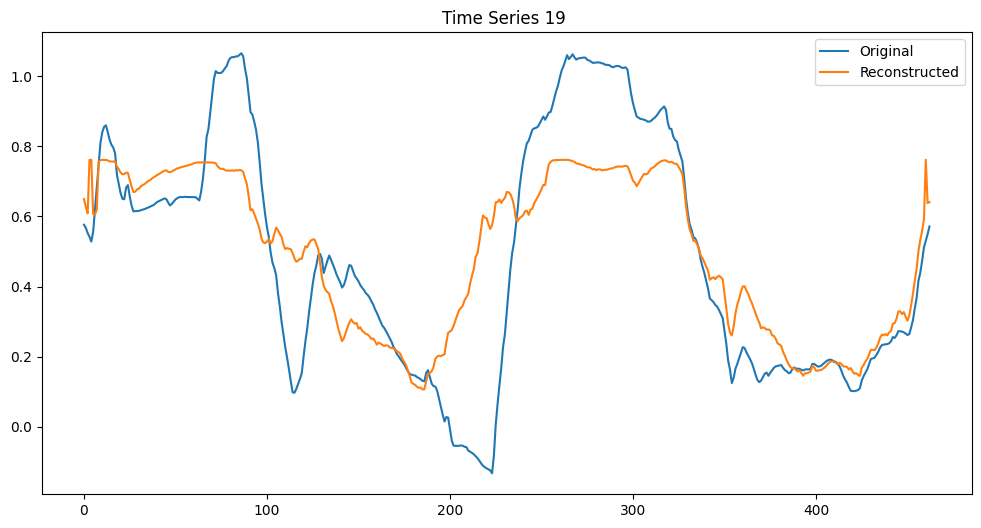

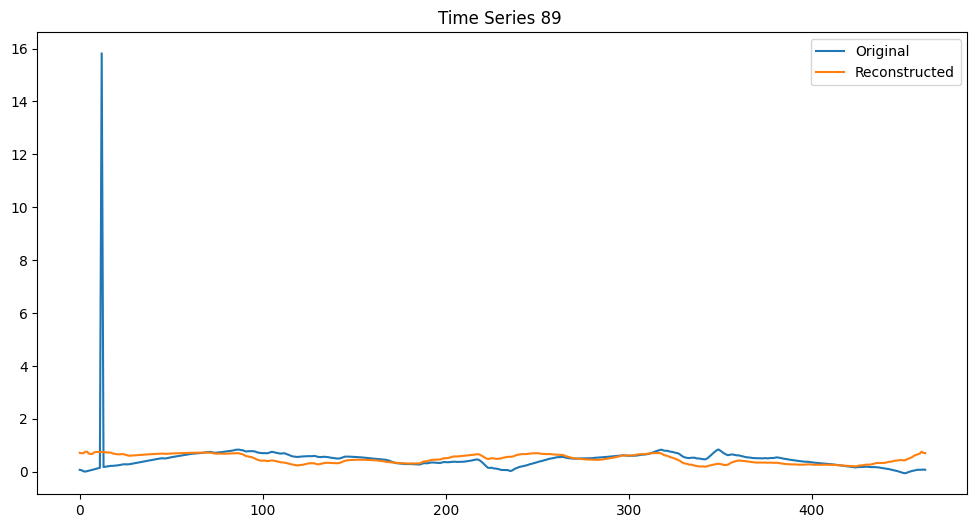

In [12]:
import matplotlib.pyplot as plt

# Plot anomalous time series with reconstructions
for index in anomalous_indices:
    original_time_series = test_dataset[index]  # Get original time series data

    # Reshape and convert to tensor
    original_time_series_reshaped = original_time_series.unsqueeze(0)  # Add batch dimension

    # Get model output for the time series
    with torch.no_grad():
        reconstructed_time_series = model(original_time_series_reshaped)

    # Convert to numpy and reshape for plotting
    original_time_series = original_time_series.numpy().reshape(-1)
    reconstructed_time_series = reconstructed_time_series.numpy().reshape(-1)

    # Create a new figure for each plot
    plt.figure(figsize=(12, 6))

    # Plot the original and reconstructed time series
    plt.plot(original_time_series, label='Original')
    plt.plot(reconstructed_time_series, label='Reconstructed')
    plt.title(f'Time Series {index} ')
    plt.legend()
    plt.show()

This autoencoder model provided in the article proved to be able to detect the one and only anomalous time series  in the dataset, which is clearly time series 89, with its anomalous spike.

Time series 19 is just the worst encoded non-anomalous time series: it has a relatively high reconstruction loss, so it falls above the 99th percentile. If we should set the anomaly threshold to the  99.9th percentile, it would fall below.

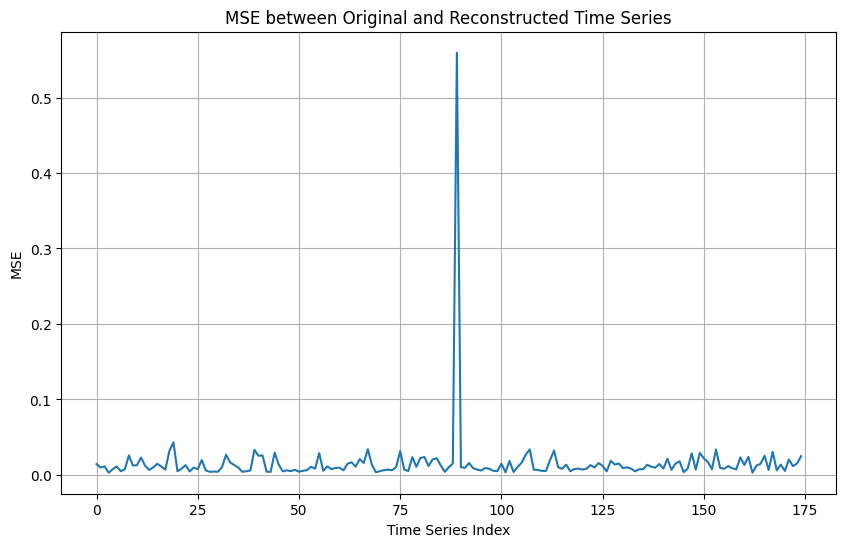

In [15]:
from sklearn.metrics import mean_squared_error

mse_values = []  # List to store MSE values

# Calculate MSE for all time series in test_dataset
for index in range(len(test_dataset)):
    original_time_series = test_dataset[index]
    original_time_series_reshaped = original_time_series.unsqueeze(0)
    with torch.no_grad():
        reconstructed_time_series = model(original_time_series_reshaped)

    # Convert to numpy for MSE calculation
    original_time_series = original_time_series.numpy().reshape(-1)
    reconstructed_time_series = reconstructed_time_series.numpy().reshape(-1)

    # Calculate MSE and append to the list
    mse = mean_squared_error(original_time_series, reconstructed_time_series)
    mse_values.append(mse)

# Plot MSE values
plt.figure(figsize=(10, 6))
plt.plot(range(len(test_dataset)), mse_values, linestyle='-', markersize=2)  # Reduced marker size
plt.title('MSE between Original and Reconstructed Time Series')
plt.xlabel('Time Series Index')
plt.ylabel('MSE')
plt.grid(True)
plt.show()